# Project: Prediction of Product Back-order

In this project, the relationship between the product back-order and other influencing factors will be explored. Further more, a model of predicting the product back-order will be set up based on relevant influencing factors.
Purpose of the project: 

## Preparation and Data Import

In [1]:
# Import libraries
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 


In [2]:
# Import 1st part of the data

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_1384d0bdfbb441ad94ffad2dfb0154d3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='NXr-YjrhjPeX9FqXF7QHipxDgD4drLk0XEjJcO5MkOl0',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_1384d0bdfbb441ad94ffad2dfb0154d3.get_object(Bucket='predictionofproductsbackorder-donotdelete-pr-omkcsrxocjv6sy',Key='Dataset_Part 2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.shape


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(242076, 23)

In [3]:
# Import 2nd part of the data
body = client_1384d0bdfbb441ad94ffad2dfb0154d3.get_object(Bucket='predictionofproductsbackorder-donotdelete-pr-omkcsrxocjv6sy',Key='Dataset_Part 1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.shape


(1687861, 23)

In [4]:
# Merge 2 parts of data together
df = df_data_1.append(df_data_2)
df.head()
df.dtypes
#df.shape

sku                   object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue       object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

## Data Transformation

### Step 1: Check duplicates

In [5]:
# Get a basic information of dataframe, remove duplicates if there is
df.describe(include="all") 
# No duplicates in "sku", so there is no need to remove duplicates regarding "sku"

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1929937.0,1.929935e+06,1.814318e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,...,1.929935e+06,1.929935e+06,1.929935e+06,1.929935e+06,1929935,1929935,1929935,1929935,1929935,1929935
unique,1929937.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,1838595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1494482,1929643,1697383,1859391,1929096,1915954
mean,NaN,4.965683e+02,7.878627e+00,4.306440e+01,1.785399e+02,3.454659e+02,5.066067e+02,5.536816e+01,1.746639e+02,3.415653e+02,...,2.016193e+00,-6.899870e+00,-6.462343e+00,6.537039e-01,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.957343e+04,7.054212e+00,1.295420e+03,5.108770e+03,9.831562e+03,1.434543e+04,1.884377e+03,5.188856e+03,9.585030e+03,...,2.296112e+02,2.659988e+01,2.588343e+01,3.543230e+01,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,...,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,...,0.000000e+00,9.600000e-01,9.500000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Evaluate and handle missing data

In [6]:
missing_data = df.isnull()

# Count missing values in each column
for column in missing_data.columns.values.tolist():
    print (column)
    print (missing_data[column].value_counts())
    print("")

sku
False    1929937
Name: sku, dtype: int64

national_inv
False    1929935
True           2
Name: national_inv, dtype: int64

lead_time
False    1814318
True      115619
Name: lead_time, dtype: int64

in_transit_qty
False    1929935
True           2
Name: in_transit_qty, dtype: int64

forecast_3_month
False    1929935
True           2
Name: forecast_3_month, dtype: int64

forecast_6_month
False    1929935
True           2
Name: forecast_6_month, dtype: int64

forecast_9_month
False    1929935
True           2
Name: forecast_9_month, dtype: int64

sales_1_month
False    1929935
True           2
Name: sales_1_month, dtype: int64

sales_3_month
False    1929935
True           2
Name: sales_3_month, dtype: int64

sales_6_month
False    1929935
True           2
Name: sales_6_month, dtype: int64

sales_9_month
False    1929935
True           2
Name: sales_9_month, dtype: int64

min_bank
False    1929935
True           2
Name: min_bank, dtype: int64

potential_issue
False    1929935
True    

In [7]:
# Since most of the columns have 2 missing values, I would like to see if there are in the same row
df[df["national_inv"].isnull()]
# The assumption is correct. The 2 missing values in most columns fall in the same rows

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242075,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop the two rows with missing values
df2=df.dropna(subset=["national_inv"],axis=0)
# Check again
missing_data2 = df2.isnull()
for column in missing_data2.columns.values.tolist():
    print (column)
    print (missing_data2[column].value_counts())
    print("")

sku
False    1929935
Name: sku, dtype: int64

national_inv
False    1929935
Name: national_inv, dtype: int64

lead_time
False    1814318
True      115617
Name: lead_time, dtype: int64

in_transit_qty
False    1929935
Name: in_transit_qty, dtype: int64

forecast_3_month
False    1929935
Name: forecast_3_month, dtype: int64

forecast_6_month
False    1929935
Name: forecast_6_month, dtype: int64

forecast_9_month
False    1929935
Name: forecast_9_month, dtype: int64

sales_1_month
False    1929935
Name: sales_1_month, dtype: int64

sales_3_month
False    1929935
Name: sales_3_month, dtype: int64

sales_6_month
False    1929935
Name: sales_6_month, dtype: int64

sales_9_month
False    1929935
Name: sales_9_month, dtype: int64

min_bank
False    1929935
Name: min_bank, dtype: int64

potential_issue
False    1929935
Name: potential_issue, dtype: int64

pieces_past_due
False    1929935
Name: pieces_past_due, dtype: int64

perf_6_month_avg
False    1929935
Name: perf_6_month_avg, dtype: int64


In [9]:
# For "lead_time", to replace missing values with the mean value
mean = df2["lead_time"].astype("float").mean(axis=0)
print("Mean value of lead time:", mean)
df2["lead_time"].replace(np.nan, mean, inplace=True)

Mean value of lead time: 7.878626569322467


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
# For "perf_6_month_avg" and "perf_12_month_avg", the rows with dummy data -99 should be removed
df2 = df2[df2.perf_6_month_avg != -99]
df2 = df2[df2.perf_12_month_avg != -99]
df2.describe(include="all")

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1781356.0,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,...,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1781356,1781356,1781356,1781356,1781356,1781356
unique,1781356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,1838595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1429923,1781064,1573188,1740183,1780934,1767929
mean,NaN,3.789841e+02,7.783747e+00,4.423556e+01,1.908162e+02,3.689796e+02,5.409138e+02,5.590278e+01,1.766283e+02,3.490371e+02,...,2.134941e+00,7.820005e-01,7.785987e-01,6.656923e-01,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,1.125091e+04,6.736117e+00,1.259623e+03,5.315002e+03,1.022678e+04,1.491881e+04,1.814183e+03,4.962907e+03,9.619018e+03,...,2.380739e+02,2.372732e-01,2.282290e-01,3.547528e+01,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.000000e-01,6.900000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,...,0.000000e+00,8.500000e-01,8.300000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,7.600000e+01,9.000000e+00,0.000000e+00,6.000000e+00,1.600000e+01,2.600000e+01,5.000000e+00,1.600000e+01,3.300000e+01,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN


### Step3: Convert categorical attributes to binary variables (Yes/No to 1/0)

In [11]:
df3=df2.copy()
df3.replace(('Yes', 'No'), (1, 0), inplace=True)
df3.head(10)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,0,0,0,1,0,0
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,0,0,1,1,0,0
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,0,0,0,1,0,0
5,3285960,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.37,0.68,0.0,0,0,0,1,0,0
13,3288094,208.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.66,0.64,0.0,0,0,0,1,0,0
15,3288487,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.37,0.34,0.0,0,0,1,1,0,0
22,3289182,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.95,0.97,0.0,0,0,0,1,0,0
30,3291632,7577.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0,0,0,1,0,0
34,3292246,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0,0,0,1,0,0
36,3292307,37.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.97,0.95,0.0,0,0,0,1,0,0


In [12]:
df3.describe(include="all")

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1781356.0,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,...,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06
unique,1781356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1838595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.789841e+02,7.783747e+00,4.423556e+01,1.908162e+02,3.689796e+02,5.409138e+02,5.590278e+01,1.766283e+02,3.490371e+02,...,2.134941e+00,7.820005e-01,7.785987e-01,6.656923e-01,1.972840e-01,1.639201e-04,1.168593e-01,9.768867e-01,2.368982e-04,7.537516e-03
std,NaN,1.125091e+04,6.736117e+00,1.259623e+03,5.315002e+03,1.022678e+04,1.491881e+04,1.814183e+03,4.962907e+03,9.619018e+03,...,2.380739e+02,2.372732e-01,2.282290e-01,3.547528e+01,3.979486e-01,1.280208e-02,3.212526e-01,1.502634e-01,1.538968e-02,8.649108e-02
min,NaN,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.000000e-01,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,NaN,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,...,0.000000e+00,8.500000e-01,8.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,NaN,7.600000e+01,9.000000e+00,0.000000e+00,6.000000e+00,1.600000e+01,2.600000e+01,5.000000e+00,1.600000e+01,3.300000e+01,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00


### Step 4: Data normalization

In [13]:
# For the quantity columns, the values need to be normalized (Min-Max Approach)
df4=df3.copy()
df4["national_inv"]= (df4["national_inv"]-df4["national_inv"].min())/(df4["national_inv"].max()-df4["national_inv"].min()) # "national_inv"
df4["lead_time"]= (df4["lead_time"]-df4["lead_time"].min())/(df4["lead_time"].max()-df4["lead_time"].min()) # "lead_time"
df4["in_transit_qty"]= (df4["in_transit_qty"]-df4["in_transit_qty"].min())/(df4["in_transit_qty"].max()-df4["in_transit_qty"].min()) # "in_transit_qty"
df4["forecast_3_month"]= (df4["forecast_3_month"]-df4["forecast_3_month"].min())/(df4["forecast_3_month"].max()-df4["forecast_3_month"].min()) # "forecast_3_month"
df4["forecast_6_month"]= (df4["forecast_6_month"]-df4["forecast_6_month"].min())/(df4["forecast_6_month"].max()-df4["forecast_6_month"].min()) # "forecast_6_month"
df4["forecast_9_month"]= (df4["forecast_9_month"]-df4["forecast_9_month"].min())/(df4["forecast_9_month"].max()-df4["forecast_9_month"].min()) # "forecast_9_month"
df4["sales_1_month"]= (df4["sales_1_month"]-df4["sales_1_month"].min())/(df4["sales_1_month"].max()-df4["sales_1_month"].min()) # "sales_1_month"
df4["sales_3_month"]= (df4["sales_3_month"]-df4["sales_3_month"].min())/(df4["sales_3_month"].max()-df4["sales_3_month"].min()) # "sales_3_month"
df4["sales_6_month"]= (df4["sales_6_month"]-df4["sales_6_month"].min())/(df4["sales_6_month"].max()-df4["sales_6_month"].min()) # "sales_6_month"
df4["sales_9_month"]= (df4["sales_9_month"]-df4["sales_9_month"].min())/(df4["sales_9_month"].max()-df4["sales_9_month"].min()) # "sales_9_month"
df4["min_bank"]= (df4["min_bank"]-df4["min_bank"].min())/(df4["min_bank"].max()-df4["min_bank"].min()) # "min_bank"
df4["pieces_past_due"]= (df4["pieces_past_due"]-df4["pieces_past_due"].min())/(df4["pieces_past_due"].max()-df4["pieces_past_due"].min()) # "pieces_past_due"
df4["perf_6_month_avg"]= (df4["perf_6_month_avg"]-df4["perf_6_month_avg"].min())/(df4["perf_6_month_avg"].max()-df4["perf_6_month_avg"].min()) # "perf_6_month_avg"
df4["perf_12_month_avg"]= (df4["perf_12_month_avg"]-df4["perf_12_month_avg"].min())/(df4["perf_12_month_avg"].max()-df4["perf_12_month_avg"].min()) # "perf_12_month_avg"
df4["local_bo_qty"]= (df4["local_bo_qty"]-df4["local_bo_qty"].min())/(df4["local_bo_qty"].max()-df4["local_bo_qty"].min()) # "local_bo_qty"
df4.describe(include="all")

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1781356.0,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,...,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06,1.781356e+06
unique,1781356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1838595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.324364e-03,1.496874e-01,9.038586e-05,1.263188e-04,1.499088e-04,1.432010e-04,7.536363e-05,1.597755e-04,1.625981e-04,...,1.457337e-05,7.820005e-01,7.785987e-01,5.312788e-05,1.972840e-01,1.639201e-04,1.168593e-01,9.768867e-01,2.368982e-04,7.537516e-03
std,NaN,1.760560e-03,1.295407e-01,2.573769e-03,3.518489e-03,4.154929e-03,3.949592e-03,2.445735e-03,4.489376e-03,4.480996e-03,...,1.625122e-03,2.372732e-01,2.282290e-01,2.831227e-03,3.979486e-01,1.280208e-02,3.212526e-01,1.502634e-01,1.538968e-02,8.649108e-02
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,4.265686e-03,7.692308e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.000000e-01,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,NaN,4.267250e-03,1.538462e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.045861e-07,1.397543e-06,...,0.000000e+00,8.500000e-01,8.300000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,NaN,4.276952e-03,1.730769e-01,0.000000e+00,3.971953e-06,6.500471e-06,6.883216e-06,6.740598e-06,1.447338e-05,1.537297e-05,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00


In [14]:
df4.head(20)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
2,3285358,0.004268,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.92,0.95,0.0,0,0,0,1,0,0
3,3285517,0.004266,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.78,0.75,0.0,0,0,1,1,0,0
4,3285608,0.004265,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.54,0.71,0.0,0,0,0,1,0,0
5,3285960,0.004267,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,4.658476e-07,...,0.0,0.37,0.68,0.0,0,0,0,1,0,0
13,3288094,0.004298,0.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.66,0.64,0.0,0,0,0,1,0,0
15,3288487,0.004265,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.37,0.34,0.0,0,0,1,1,0,0
22,3289182,0.004266,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.95,0.97,0.0,0,0,0,1,0,0
30,3291632,0.005451,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.00,0.00,0.0,0,0,0,1,0,0
34,3292246,0.004265,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.00,0.00,0.0,0,0,0,1,0,0
36,3292307,0.004271,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.0,0.97,0.95,0.0,0,0,0,1,0,0


### Step 5: Explore the correlation

In [15]:
# Remove the SKUs for which forecast and sales are 0 and the target class “Went to Back order is also “No”
df5=df4.copy()
indexNames = df5[ (df5['forecast_3_month'] == 0) & (df5['forecast_6_month'] == 0) & (df5['forecast_9_month'] == 0) & (df5['sales_1_month'] == 0) & (df5['sales_3_month'] == 0) & (df5['sales_6_month'] == 0) & (df5['sales_9_month'] == 0) & (df5['went_on_backorder'] == 0)].index
df5.drop(indexNames , inplace=True)

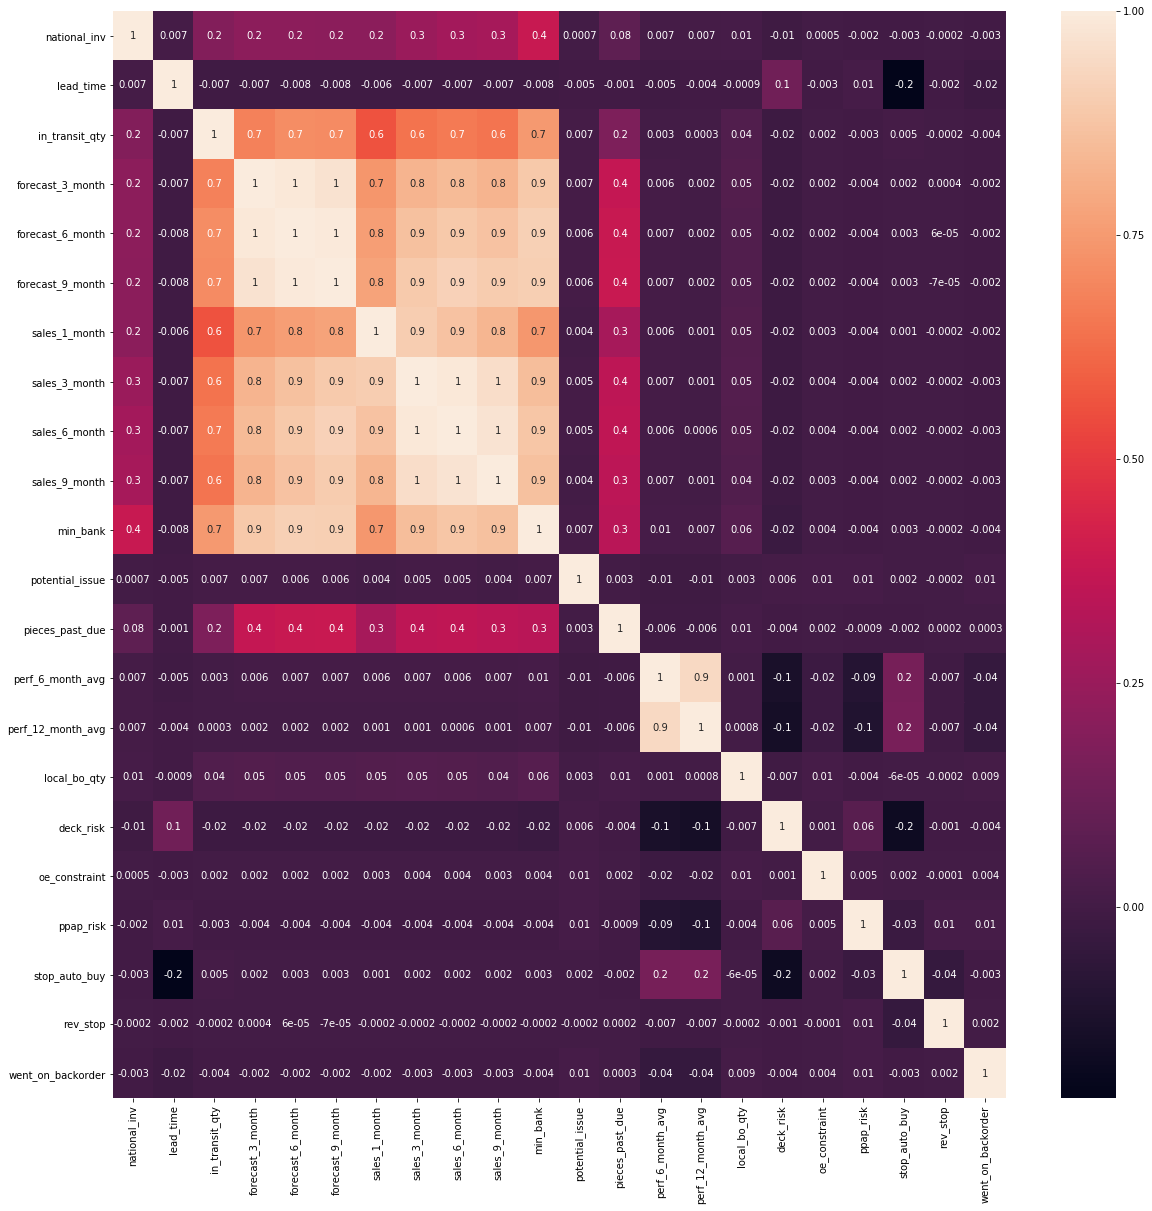

In [16]:
# Draw a correlation heatmap for all variants
plt.figure(figsize=(20,20))
sns.heatmap(df5.corr(), annot = True, fmt='.1g')

In [17]:
# Remove the rows which are highly correlated with each other
df6=df5.copy()
df6.drop(columns=['forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'perf_12_month_avg'], inplace = True)



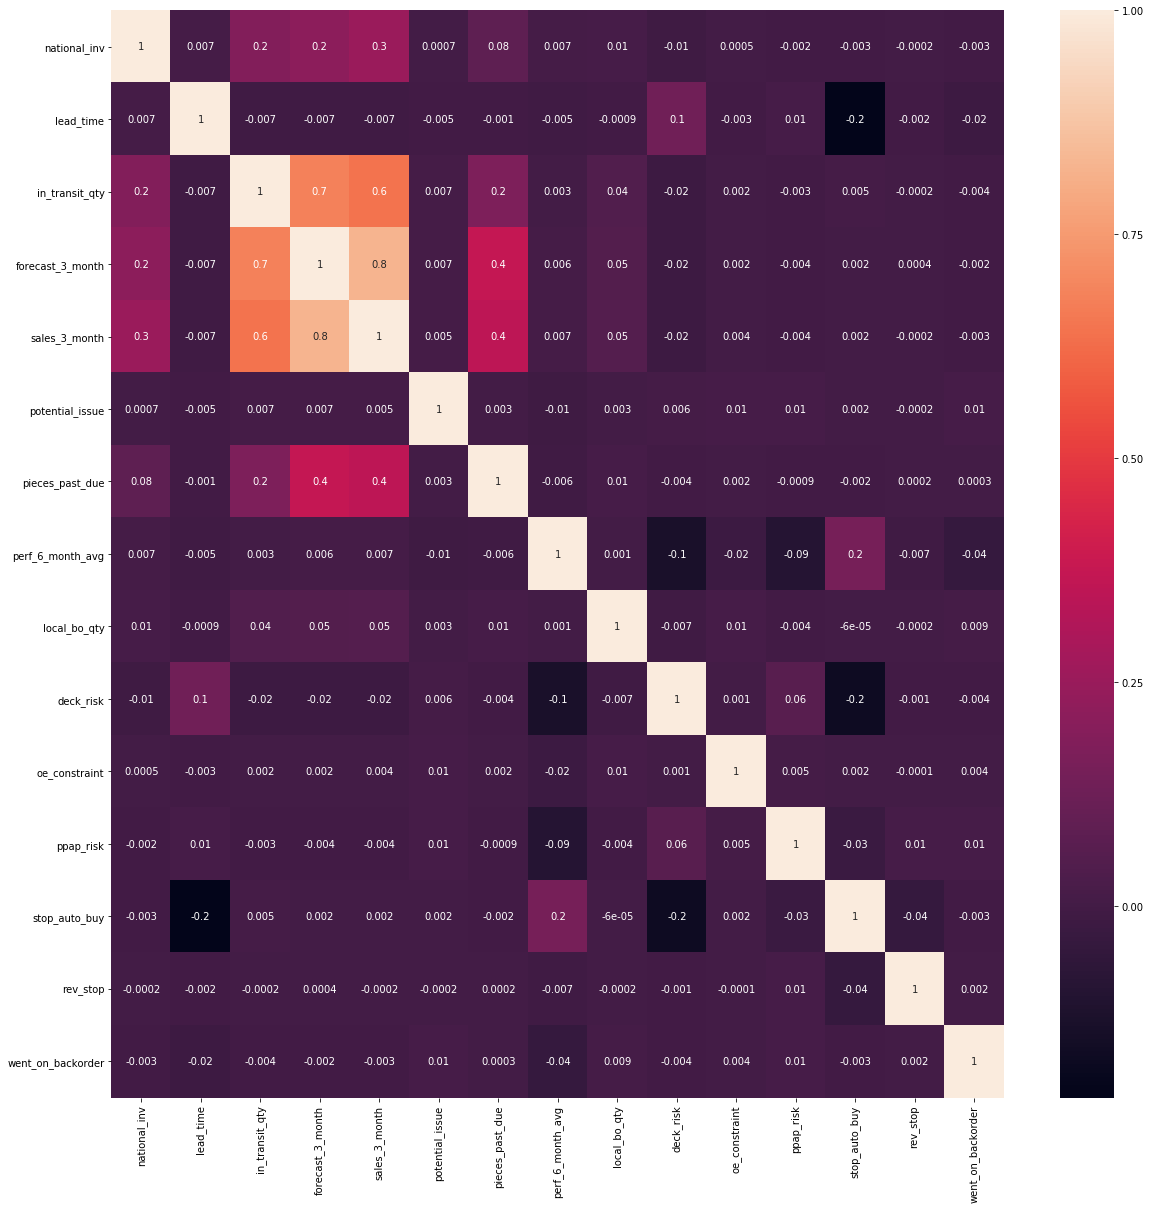

In [18]:
# Draw a correlation heatmap for all variants
plt.figure(figsize=(20,20))
sns.heatmap(df6.corr(), annot = True, fmt='.1g')

## Data Selection and Modelling (imbalanced)

In [19]:
df6.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
101,3330618,0.004265,0.153846,0.0,0.0,0.0,0,0.0,0.96,0.0,0,0,0,1,0,0
175,3354663,0.004276,0.076923,0.0,0.0,0.0,0,0.0,0.35,0.0,0,0,0,1,0,0
210,3370974,0.004266,0.038462,0.0,0.0,0.0,0,0.0,0.99,0.0,0,0,0,1,0,0
226,3376248,0.004273,0.038462,0.0,0.0,0.0,0,0.0,0.48,0.0,1,0,0,1,0,0
254,3385403,0.004266,0.153846,0.0,0.0,0.0,0,0.0,0.90,0.0,0,0,0,1,0,0


In [20]:
# Define X
X = np.asarray(df6[['national_inv', 'forecast_3_month', 'sales_3_month', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg', 'local_bo_qty']])
X[0:5]

array([[0.00426537, 0.        , 0.        , 0.        , 0.        ,
        0.96      , 0.        ],
       [0.00427586, 0.        , 0.        , 0.        , 0.        ,
        0.35      , 0.        ],
       [0.00426584, 0.        , 0.        , 0.        , 0.        ,
        0.99      , 0.        ],
       [0.0042732 , 0.        , 0.        , 0.        , 0.        ,
        0.48      , 0.        ],
       [0.00426553, 0.        , 0.        , 0.        , 0.        ,
        0.9       , 0.        ]])

In [21]:
# Define y
y = np.asarray(df6['went_on_backorder'])
y [0:5]

array([0, 0, 0, 0, 0])

In [22]:
# Split the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (948873, 7) (948873,)
Test set: (237219, 7) (237219,)


In [23]:
# Modeling (Logistic Regression with Scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
# Predict using the test set
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
# Evaluation (Confusion Matrix)
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[     0   2461]
 [     0 234758]]


Confusion matrix, without normalization
[[     0   2461]
 [     0 234758]]


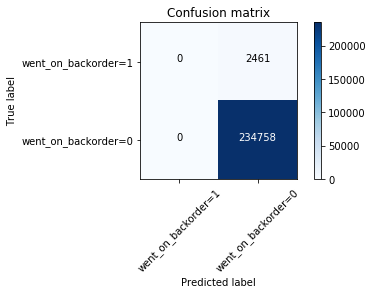

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['went_on_backorder=1','went_on_backorder=0'],normalize= False,  title='Confusion matrix')

## Data Modelling 1.0 (balanced, with all 14 features)

In [27]:
# For the target value 'went_on_backorder', the majority class ("No") significantly outweighs the minority class ("Yes") -- 100:1
df6['went_on_backorder'].value_counts()


0    1173958
1      12134
Name: went_on_backorder, dtype: int64

In [28]:
# Split the dataframe according to 'went_on_backorder' (Yes or No)
df_bo_yes = df6[df6['went_on_backorder'] == 1]
df_bo_no = df6[df6['went_on_backorder'] == 0]
df_bo_no['went_on_backorder'].value_counts()

0    1173958
Name: went_on_backorder, dtype: int64

In [29]:
# Randomly pick samples from the majority
df_bo_no_sample = df_bo_no.sample(frac=0.02, replace=False, random_state=1)
df_bo_no_sample['went_on_backorder'].value_counts()

0    23479
Name: went_on_backorder, dtype: int64

In [30]:
# Merge datasets and split into training set and test set
df_sample= df_bo_no_sample.append(df_bo_yes)
df_sample['went_on_backorder'].value_counts()
df_sample.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_3_month,potential_issue,pieces_past_due,perf_6_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
94040,1205540,0.004283,0.173077,0.0,0.0,0.000034,0,0.0,1.00,0.0,0,0,0,1,0,0
274970,1622958,0.004271,0.153846,0.0,0.0,0.000018,0,0.0,0.98,0.0,0,0,0,1,0,0
427758,1775737,0.004272,0.153846,0.0,0.0,0.000004,0,0.0,0.98,0.0,0,0,1,1,0,0
1124742,1489351,0.004267,0.153846,0.0,0.0,0.000000,0,0.0,0.80,0.0,0,0,1,1,0,0
1252008,2834023,0.004269,0.230769,0.0,0.0,0.000000,0,0.0,0.57,0.0,0,0,0,1,0,0


In [31]:
# Define X
X = np.asarray(df_sample[['national_inv','lead_time','in_transit_qty', 'forecast_3_month', 'sales_3_month', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg', 'local_bo_qty','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']])
X[0:5]

array([[4.28e-03, 1.73e-01, 0.00e+00, 0.00e+00, 3.44e-05, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00],
       [4.27e-03, 1.54e-01, 0.00e+00, 0.00e+00, 1.81e-05, 0.00e+00,
        0.00e+00, 9.80e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00],
       [4.27e-03, 1.54e-01, 0.00e+00, 0.00e+00, 3.62e-06, 0.00e+00,
        0.00e+00, 9.80e-01, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00],
       [4.27e-03, 1.54e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 8.00e-01, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00],
       [4.27e-03, 2.31e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 5.70e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00]])

In [32]:
# Define y
y = np.asarray(df_sample['went_on_backorder'])
y [0:5]

array([0, 0, 0, 0, 0])

In [33]:
# Split the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (28490, 14) (28490,)
Test set: (7123, 14) (7123,)


In [34]:
# Modeling (Logistic Regression with Scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR2 = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
LR2

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
# Predict using the test set
yhat = LR2.predict(X_test)
yhat


array([0, 0, 0, ..., 0, 0, 0])

In [36]:
# Evaluation (Confusion Matrix)
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 299 2103]
 [ 235 4486]]


Confusion matrix, without normalization
[[ 299 2103]
 [ 235 4486]]


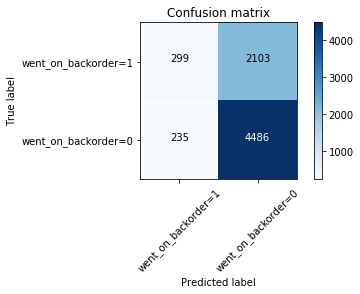

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['went_on_backorder=1','went_on_backorder=0'],normalize= False,  title='Confusion matrix')

In [38]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79      4721
           1       0.56      0.12      0.20      2402

   micro avg       0.67      0.67      0.67      7123
   macro avg       0.62      0.54      0.50      7123
weighted avg       0.64      0.67      0.59      7123



In [39]:
# Log Loss
yhat_prob = LR2.predict_proba(X_test)
yhat_prob
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6178994480593926

## Data selection

[-6.29e-02 -1.67e+00 -7.57e-02 -5.24e-02 -1.14e-01  8.89e-01  8.63e-04
 -1.26e+00  2.09e-01 -2.99e-01 -4.84e-02  1.81e-01  1.00e-02  0.00e+00]


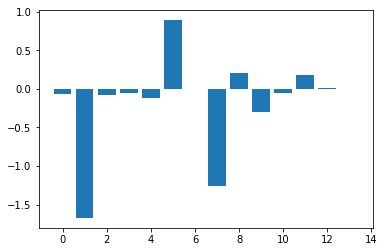

In [40]:
# get importance
importance = LR2.coef_[0]
print(importance)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Data Modelling 2.0 (balanced, with 7 selected features)

In [41]:
# Define X
X = np.asarray(df_sample[['lead_time', 'sales_3_month', 'potential_issue',  'perf_6_month_avg', 'local_bo_qty','deck_risk','ppap_risk']])
X[0:5]

array([[1.73e-01, 3.44e-05, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00],
       [1.54e-01, 1.81e-05, 0.00e+00, 9.80e-01, 0.00e+00, 0.00e+00,
        0.00e+00],
       [1.54e-01, 3.62e-06, 0.00e+00, 9.80e-01, 0.00e+00, 0.00e+00,
        1.00e+00],
       [1.54e-01, 0.00e+00, 0.00e+00, 8.00e-01, 0.00e+00, 0.00e+00,
        1.00e+00],
       [2.31e-01, 0.00e+00, 0.00e+00, 5.70e-01, 0.00e+00, 0.00e+00,
        0.00e+00]])

In [42]:
# Define y
y = np.asarray(df_sample['went_on_backorder'])
y [0:5]

array([0, 0, 0, 0, 0])

In [43]:
# Split the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (28490, 7) (28490,)
Test set: (7123, 7) (7123,)


In [44]:
# Modeling (Logistic Regression with Scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR3 = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)
LR3

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
# Predict using the test set
yhat = LR3.predict(X_test)
yhat


array([0, 0, 0, ..., 0, 0, 0])

In [46]:
# Evaluation (Confusion Matrix)
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 299 2103]
 [ 235 4486]]


Confusion matrix, without normalization
[[ 299 2103]
 [ 235 4486]]


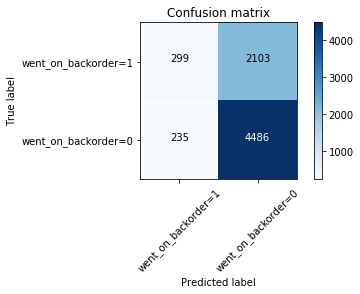

In [47]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['went_on_backorder=1','went_on_backorder=0'],normalize= False,  title='Confusion matrix')

In [48]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79      4721
           1       0.56      0.12      0.20      2402

   micro avg       0.67      0.67      0.67      7123
   macro avg       0.62      0.54      0.50      7123
weighted avg       0.64      0.67      0.59      7123



[-1.67 -0.11  0.88 -1.26  0.21 -0.3   0.18]


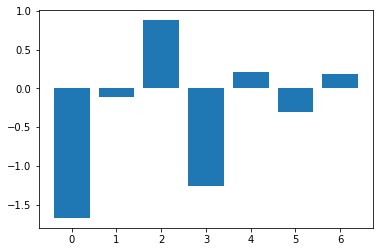

In [49]:
# get importance
importance = LR3.coef_[0]
print(importance)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()